In [59]:
# imports
from pathlib import Path
import geopandas as gpd
from geocube.api.core import make_geocube
import rasterio
import rasterio.plot
import numpy as np

In [62]:
# initialize paths etc.
url = "https://data.cityofnewyork.us/api/geospatial/qb5r-6dgf?method=export&format=Shapefile"
data_path = Path("data")
reference_raster = rasterio.open(data_path / "landcover_2010_nyc_3ft_mn.tif")

In [5]:
# pull down bldg shp via url
bldg_gdf = gpd.read_file(filename=url, engine="pyogrio")


In [27]:
bldg_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
# to_crs 2263
bldg_gdf.to_crs(epsg="2263",inplace=True)
# export gdf as geoparquet
out_data_name = "buildings"
file_ext = "parquet"
bldg_gdf.to_parquet(data_path / f"{out_data_name}.{file_ext}")

In [ ]:
bldg_gdf.crs

In [32]:
# read geoparquet into a gdf
bldg_gdf = gpd.read_parquet(data_path / f"{out_data_name}.{file_ext}")

print(f"num of rows in bldg dataset: {len(bldg_gdf)}")

num of rows in bldg dataset: 1083122


In [38]:
# calculate roof height relative to sealevel, not grade
bldg_gdf["roof_hgt_from_sealvl"] = (bldg_gdf.heightroof + bldg_gdf.groundelev).round(0)

In [ ]:
bldg_gdf.head()

In [47]:
# subset geoparquet to only include SI

mn_bldg_gdf = bldg_gdf.query("base_bbl.str.startswith('1')")

print(f"num of rows in mn bldg dataset: {len(mn_bldg_gdf)}")

num of rows in mn bldg dataset: 45336


<Axes: >

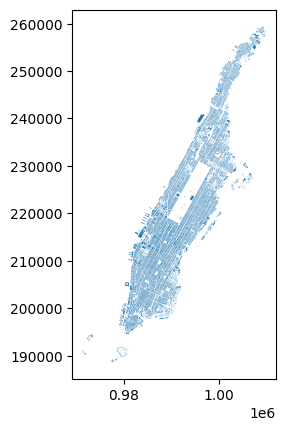

In [48]:
mn_bldg_gdf.plot()

In [56]:
## rasterize bldg footprints

geom = [shapes for shapes in mn_bldg_gdf.geometry]

# create tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = (
    (geom, value)
    for geom, value in zip(mn_bldg_gdf.geometry, mn_bldg_gdf["roof_hgt_from_sealvl"])
)

# Rasterize vector using the shape and transform of the raster
rasterized = rasterio.features.rasterize(
    geom_value,
    out_shape=reference_raster.shape,
    transform=reference_raster.transform,
    all_touched=True,
    fill=-5,  # background value
    merge_alg=rasterio.enums.MergeAlg.replace,
    # dtype=np.int16,
)

In [61]:
with rasterio.open(
        data_path / "mn_bldg_raster.tif", "w",
        driver = "GTiff",
        crs = reference_raster.crs,
        transform = reference_raster.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = reference_raster.width,
        height = reference_raster.height) as dst:
    dst.write(rasterized, indexes = 1)

/Users/jackrosacker/files/projects/building-viewshed/.venv/lib/python3.12/site-packages/numpy/core/_asarray.py:126: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


In [63]:
mn_bldg_raster = rasterio.open(data_path / "mn_bldg_raster.tif")

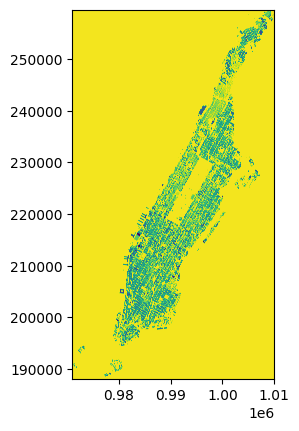

<Axes: >

In [64]:
rasterio.plot.show(mn_bldg_raster)